In [4]:
import numpy as np
from scipy.constants import Boltzmann as k
from numpy.typing import NDArray
from typing import List
import matplotlib.pyplot as plt
from numba import jit
import numba as nb
from scipy.ndimage import convolve, generate_binary_structure
from collections import Counter
from collections import defaultdict

In [5]:
N = 3
@nb.njit(parallel=True)
def generate_lattice(L: int, p: float = 0.5) -> np.ndarray:
    init_lattice = np.empty((L, L), dtype=np.float32)
    for i in nb.prange(L):
        for j in range(L):
            # Generate a random number for each element
            random_value = np.random.random()
            if random_value >= p:
                init_lattice[i, j] = 1
            else:
                init_lattice[i, j] = -1
    return init_lattice

state = generate_lattice(50, 0.5)

In [6]:
print(state)

[[ 1.  1.  1. ... -1.  1.  1.]
 [-1. -1.  1. ... -1. -1.  1.]
 [-1. -1.  1. ...  1. -1.  1.]
 ...
 [ 1. -1. -1. ...  1. -1. -1.]
 [ 1.  1.  1. ...  1.  1. -1.]
 [ 1. -1.  1. ...  1.  1. -1.]]


In [7]:
def energy_naive(lattice: np.ndarray) -> int:
    H = 0
    for row in lattice:
        H += (np.sum(row[:-1] * row[1:]) + row[0]*row[-1])
    
    for col in lattice.T:
        H += (np.sum(col[:-1] * col[1:]) + col[0]*col[-1])

    return -H


In [8]:
def energy_conv(lattice: np.ndarray) -> int:
    kern = generate_binary_structure(2,1)
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode = "wrap")
    return arr.sum()/2

In [9]:
import numpy as np
from numba import jit

@jit(nopython=True)  # Use the nopython mode for better performance
def energy_numba(lattice: np.ndarray) -> int:
    H = 0
    N = lattice.shape[0]
    M = lattice.shape[1]

    # Calculate horizontal interactions with periodic boundary conditions
    for i in range(N):
        for j in range(M):
            right_neighbor = (j + 1) % M  # Wrap around horizontally
            H += lattice[i, j] * lattice[i, right_neighbor]

    # Calculate vertical interactions with periodic boundary conditions
    for i in range(N):
        for j in range(M):
            down_neighbor = (i + 1) % N  # Wrap around vertically
            H += lattice[i, j] * lattice[down_neighbor, j]

    return -H

In [10]:
import numba as nb
@jit(parallel=True)
def energy(lattice: np.ndarray) -> int:
    N, M = lattice.shape  # Assuming a square lattice for simplicity
    H = 0.0
    
    # Loop over all elements to calculate horizontal and vertical interactions
    # Parallelize the outer loop
    for i in nb.prange(N):
        for j in range(M):
            right_neighbor = (j + 1) % M
            down_neighbor = (i + 1) % N
            
            # Periodic boundary conditions are handled by wrapping index
            H += lattice[i, j] * (lattice[i, right_neighbor] + lattice[down_neighbor, j])
    
    return -H

In [11]:
print(energy(state))

152.0


In [12]:
print(energy_numba(state))

152.0


In [13]:
print(energy_naive(state))

152.0


In [14]:
print(energy_conv(state))

152.0


In [76]:
def plot_lattice(lattice, title = None):
    plt.imshow(lattice, cmap = plt.cm.colors.ListedColormap(['#0000FF', '#FF0000']))
    if title:
        plt.savefig(title)

In [122]:
def plot_multiple_lattice(lattice, ax, title=None):
    cmap = plt.cm.colors.ListedColormap(['#0000FF', '#FF0000'])  # Blue and Red colormap
    ax.imshow(lattice, cmap=cmap)
    if title:
        ax.set_title(title)

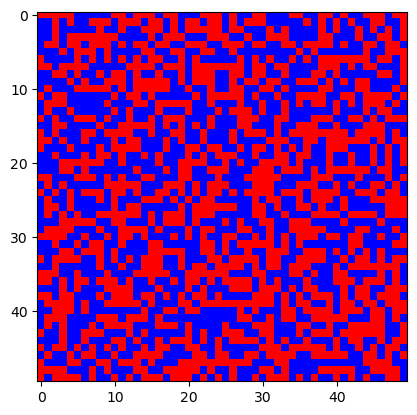

In [77]:
plot_lattice(state)

In [18]:
@jit(nopython=True)
def delta_energy(initial_lattice: np.ndarray, spin_to_flip: tuple[int, int]) -> int:
    #Calculates E_new - E_old
    L = initial_lattice.shape[0]
    sum_of_neighbors = 0
    x,y = spin_to_flip[0], spin_to_flip[1]

    sum_of_neighbors = (initial_lattice[(x + 1)%L, y] +
                        initial_lattice[(x - 1)%L, y] +
                        initial_lattice[x, (y + 1)%L] +
                        initial_lattice[x, (y - 1)%L])
     
    return 2 * sum_of_neighbors * initial_lattice[x, y]


In [19]:
@jit(nopython=True)
def flip_spin_in_lattice(lattice: np.ndarray, spin: tuple[int,int]) -> np.ndarray:
    #given a lattice l, return a new lattice l'
    new_lattice = lattice.copy()
    new_lattice[spin] *= -1
    return new_lattice

In [20]:
@jit(nopython=True)
def flip_random_spin(lattice: np.ndarray) -> tuple[int, int]:
    L = lattice.shape[0]
    x, y = np.random.randint(0, L), np.random.randint(0, L)
    return (x,y)

In [21]:
cand_spin = flip_random_spin(state)
print(delta_energy(state, cand_spin), energy(flip_spin_in_lattice(state, cand_spin)) - energy(state))

-4.0 -4.0


In [22]:
def magnetization(lattice: np.ndarray) -> float:
    return np.sum(lattice)

In [23]:
@jit(nopython=True)
def sampler(type: str,init_dist: np.ndarray, beta: float, num_iters: int, sweep_size: int = 50):
    fixed_time_samples = []
    updated_samples = []
    sample = init_dist.copy()
    for i in range(num_iters):
        candidate_spin = flip_random_spin(sample)
        if type == "mh":
            acceptance_prop = min(1, np.exp(-beta * delta_energy(sample, candidate_spin)))
        elif type == "gibbs":
            acceptance_prop = 1/(1 + 1/np.exp(-beta * delta_energy(sample, candidate_spin)))
        else:
            print("error, sampler type must either be mh or gibbs")
            break
        if (acceptance_prop > np.random.random()):  
            sample = flip_spin_in_lattice(sample, candidate_spin)
            updated_samples.append(sample)
        if i % sweep_size == 0:
            fixed_time_samples.append(sample)
    return fixed_time_samples, updated_samples
            

In [491]:
N, p, beta = 25, 0.75, 0.44

In [492]:
mh_fixed_time_res, mh_updated_res = sampler('mh', generate_lattice(N, p), beta, 2_000_000)
print(len(mh_fixed_time_res), len(mh_updated_res))

40000 361275


In [493]:
gibbs_fixed_time_res, gibbs_updated_res = sampler('gibbs', generate_lattice(N, p), beta, 2_000_000)
print(len(gibbs_fixed_time_res), len(gibbs_updated_res))


40000 277916


In [24]:
def plot_magnetization_squared(samples: list):
    samples = np.array(samples)
    magnetization_squared_of_samples = (np.mean(samples, axis = (1,2)) ** 2)
    plt.plot(magnetization_squared_of_samples)
    plt.xlabel("number_of_iters / 10")
    plt.ylabel("magnetization squared per lattice site")
    plt.title("Magnetization density squared")
    plt.savefig("mag_sq_density_mh")

In [25]:
def plot_magnetization(samples: list):
    samples = np.array(samples)
    magnetization_of_samples = (np.mean(samples, axis = (1,2)))
    plt.plot(magnetization_of_samples)
    plt.xlabel("number_of_iters / 10")
    plt.ylabel("magnetization squared per lattice site")
    plt.title("Magnetization density")


In [26]:
def plot_energy(samples: list):
    L = samples[0].shape[0]
    energy_of_samples = [energy(sample)/(L**2) for sample in samples]
    plt.plot(energy_of_samples)
    plt.xlabel("number_of_iters / 10")
    plt.ylabel("Energy per lattice site")
    plt.title("Energy density")
    plt.savefig("energy_density_gibbs")


In [515]:
mh_converge_test_fixed_time_res, mh_converge_test_updated_res = \
    sampler('mh', generate_lattice(40, 0.4), 0.45, 300_000, 10)

gibbs_converge_test_fixed_time_res, gibbs_converge_test_updated_res = \
    sampler('gibbs', generate_lattice(40, 0.4), 0.45, 300_000, 10)

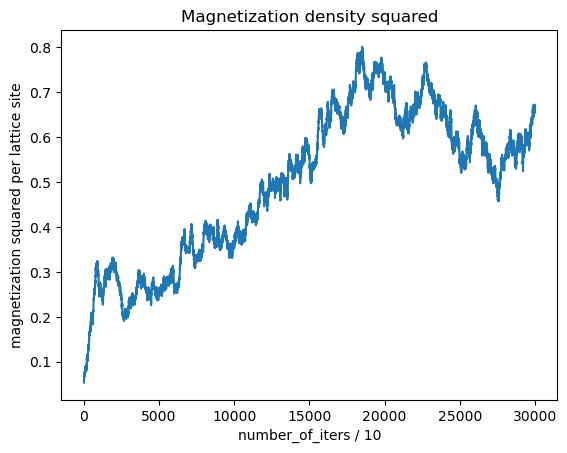

In [535]:
plot_magnetization_squared(mh_converge_test_fixed_time_res)

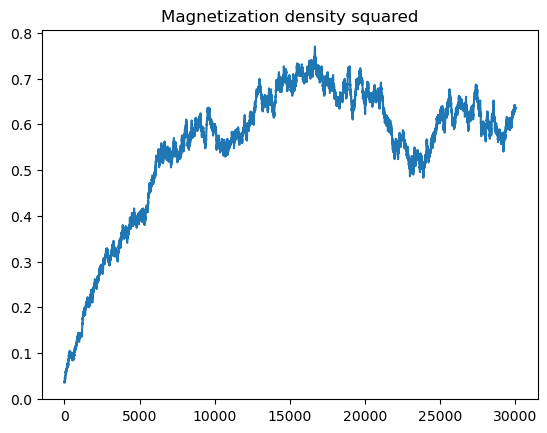

In [525]:
plot_magnetization_squared(gibbs_converge_test_fixed_time_res)

In [27]:
def get_converged_samples(updated_samples: list) -> np.ndarray:
    n = len(updated_samples)
    return np.array(updated_samples[-n // 4:])

In [40]:
def average_magnetization(samples: list) -> float:
    converged_samples = get_converged_samples(samples)
    magnetization_samples = (np.mean(converged_samples, axis = (1,2)))
    return np.mean(magnetization_samples)

In [38]:
average_magnetization(gibbs_updated_res)

0.027957585

In [39]:
average_magnetization(mh_updated_res)

0.34929302

In [29]:
def average_energy(samples: list) -> float:
    L = samples[0].shape[0]
    converged_samples = get_converged_samples(samples)
    energy_of_samples = np.array([energy(sample)/(L**2) for sample in converged_samples])
    return np.mean(energy_of_samples)

In [539]:
def heat_capacity(samples: list, beta: float) -> float:
    L = samples[0].shape[0]
    converged_samples = get_converged_samples(samples)
    energy_of_samples = np.array([energy(sample) for sample in converged_samples])
    var_of_energy = np.var(energy_of_samples)/(L**2)
    return k*(beta**2)*var_of_energy

In [49]:
average_energy(gibbs_updated_res)

-3346.3316647729016

In [42]:
average_energy(mh_updated_res)

-3519.787306538692

In [2]:
betas = [0, 0.1, 0.2, 0.3, 0.35, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1]
n_vals = [6, 10, 16, 25]

In [38]:

for beta in betas:
    Cv_gibbs_fixed_time, Cv_gibbs_update = sampler('gibbs', generate_lattice(25, 0.25), beta, 2_500_000)
    final_magnetization.append(average_magnetization(Cv_gibbs_update))

In [133]:
diff_beta_lattice = []
betas_diff_lattice = [0.2, 0.3, 0.4, 0.42, 0.4407, 0.461, 0.49, 0.6, 0.75]
for beta in betas_diff_lattice :  
    diff_beta_gibbs_fixed_time, diff_beta_gibbs_update = sampler('gibbs', generate_lattice(25, 0.6), beta, 3_000_000)
    diff_beta_lattice.append(diff_beta_gibbs_update[-1])

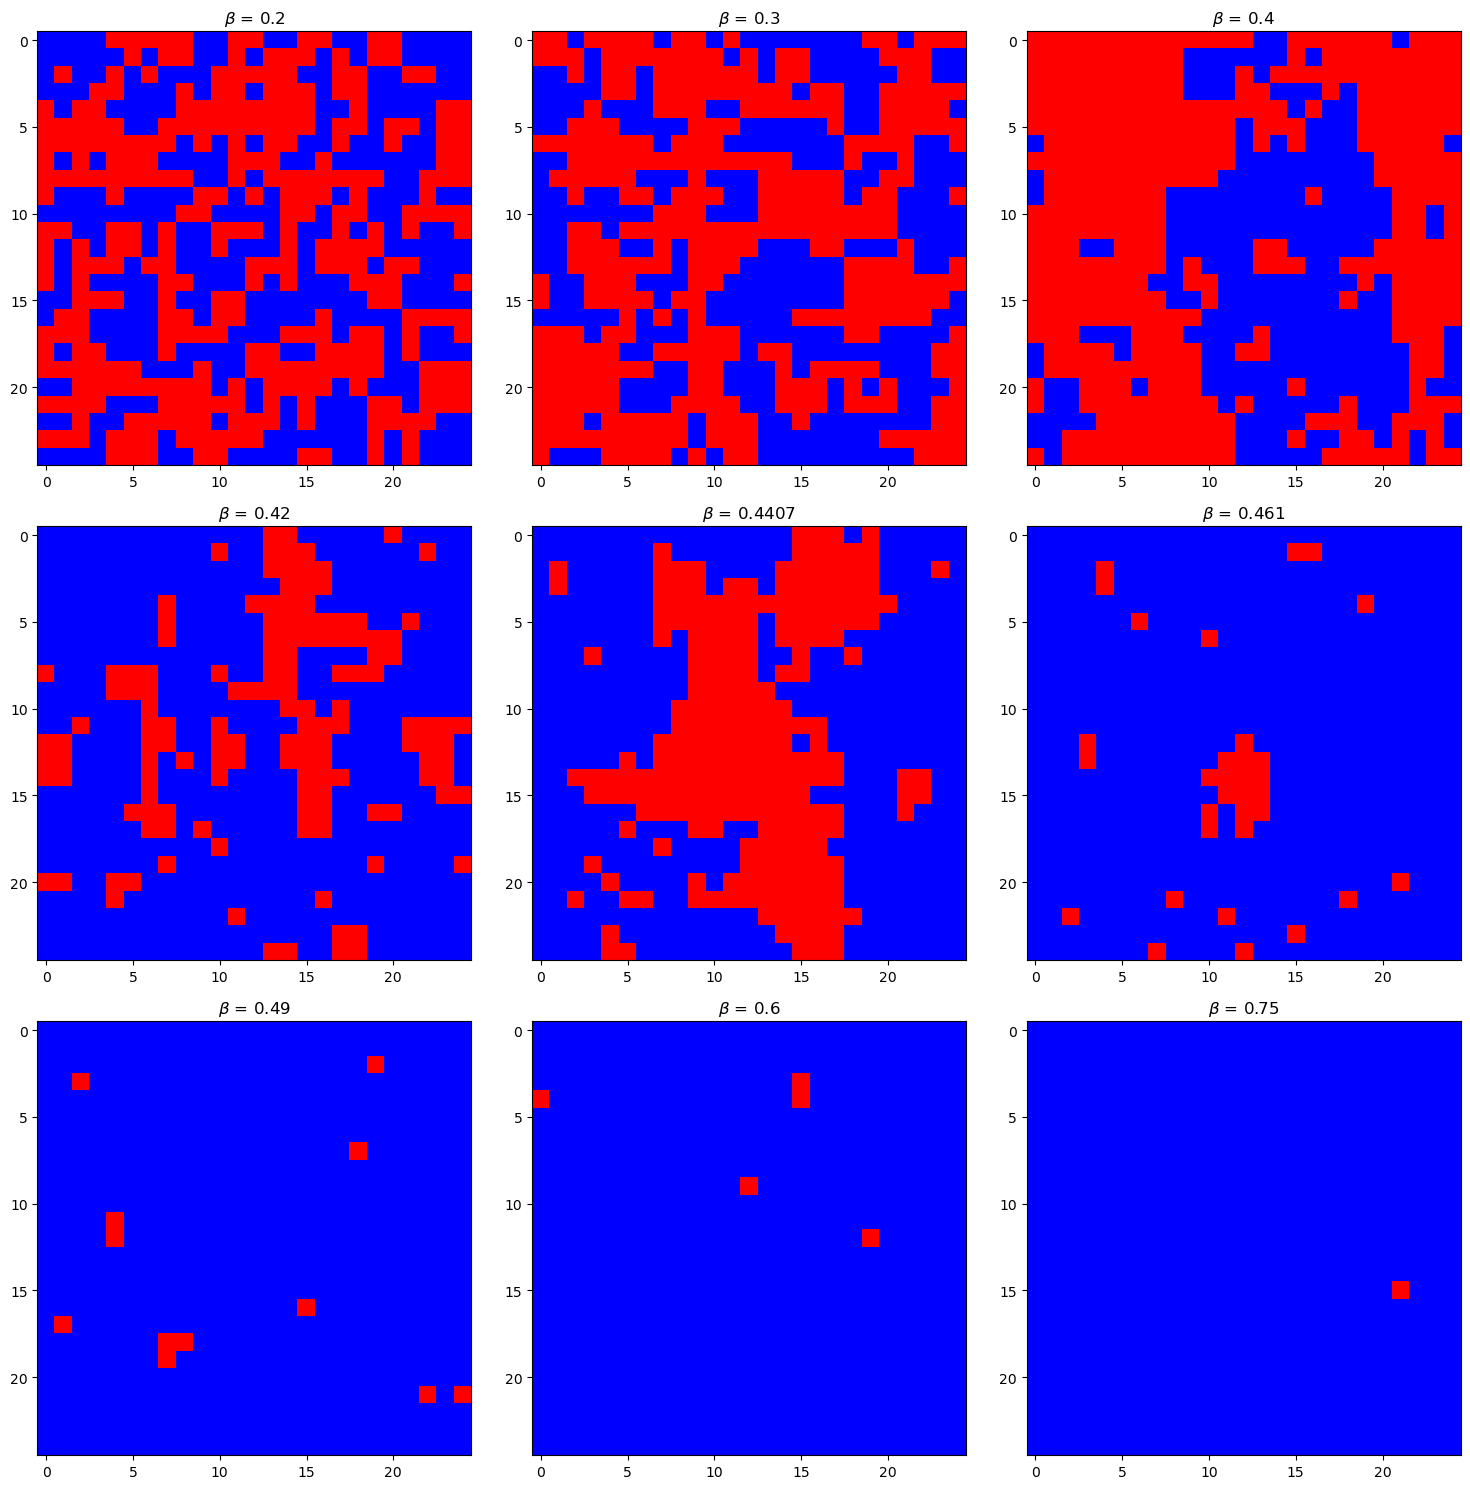

In [136]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for ax, lattice,beta in zip(axs.ravel(), diff_beta_lattice, betas_diff_lattice ):
    plot_multiple_lattice(lattice, ax, title = rf"$\beta$ = {beta}")

plt.tight_layout()

plt.savefig("multiple_lattices.png")

In [70]:
res = []
for up_percentage in [0.75]:
    res_run = []
    for beta in betas:
        Cv_gibbs_fixed_time, Cv_gibbs_update = sampler('gibbs', generate_lattice(16, up_percentage), beta, 2_000_000)
        res_run.append(average_magnetization(Cv_gibbs_update))
    res.append(res_run)

In [68]:
spin_up_run = res[0]

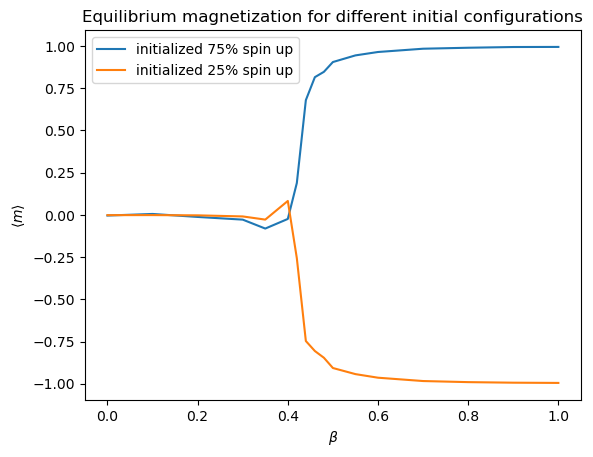

In [71]:

plt.plot(betas, spin_up_run, label = "initialized 75% spin up")
plt.plot(betas, res[0], label = "initialized 25% spin up")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\langle m \rangle$")
plt.legend()
plt.title("Equilibrium magnetization for different initial configurations")
plt.savefig("diff_spin_initializations")

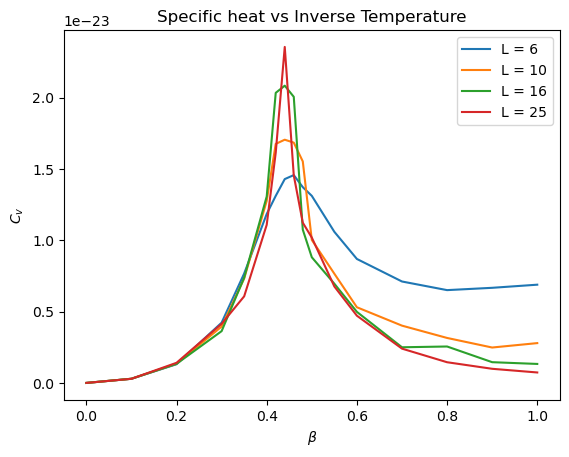

In [548]:
for n in n_vals:
    Cv = []
    for beta in betas:
        Cv_gibbs_fixed_time, Cv_gibbs_update = sampler('gibbs', generate_lattice(n, 0.5), beta, 2_000_000)
        Cv.append(heat_capacity(Cv_gibbs_update, beta))
    plt.plot(betas, Cv, label =  f"L = {n}")

plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$C_v$')
plt.title("Specific heat vs Inverse Temperature")
plt.savefig("specific_heat.png")


In [51]:
grid_mh_energy = []
grid_mh_mag = []
grid_gibbs_energy = []
grid_gibbs_mag = []

for n in n_vals:
    n_grid_mh_energy = []
    n_grid_mh_mag = []
    n_grid_gibbs_energy = []
    n_grid_gibbs_mag = []
    
    for beta in betas:
        n_grid_mh_fixed_time_samples, n_grid_mh_updated_samples = sampler('mh', generate_lattice(n, 0.5), beta, 2_000_000)
        n_grid_gibbs_fixed_time_samples, n_grid_gibbs_updated_samples = sampler('gibbs', generate_lattice(n, 0.5), beta, 2_000_000)
        print(beta, n, len(n_grid_mh_updated_samples), len(n_grid_gibbs_updated_samples))
        n_grid_mh_energy.append(average_energy(n_grid_mh_updated_samples))
        n_grid_mh_mag.append(average_magnetization(n_grid_mh_updated_samples))
        n_grid_gibbs_energy.append(average_energy(n_grid_gibbs_updated_samples))
        n_grid_gibbs_mag.append(average_magnetization(n_grid_gibbs_updated_samples))

    grid_mh_energy.append(n_grid_mh_energy)
    grid_mh_mag.append(n_grid_mh_mag)

    grid_gibbs_energy.append(n_grid_gibbs_energy)
    grid_gibbs_mag.append(n_grid_gibbs_mag)

0 6 2000000 998698
0.1 6 1697146 961072
0.2 6 1382759 849905
0.3 6 1015155 665207
0.35 6 785272 531991
0.4 6 516312 369537
0.42 6 417144 303138
0.44 6 323839 250205
0.46 6 257316 200117
0.48 6 204657 161211
0.5 6 156043 130358
0.55 6 88830 77204
0.6 6 50806 47434
0.7 6 19541 19100
0.8 6 7861 7800
0.9 6 3514 3329
1 6 1553 1499
0 10 2000000 999955
0.1 10 1698429 960427
0.2 10 1384576 849232
0.3 10 1042309 674532
0.35 10 843677 563358
0.4 10 575393 399132
0.42 10 464847 338756
0.44 10 355972 261270
0.46 10 275608 209971
0.48 10 206180 165266
0.5 10 159955 130783
0.55 10 88600 78302
0.6 10 51151 47450
0.7 10 20163 19071
0.8 10 8490 7958
0.9 10 3636 3340
1 10 1628 1531
0 16 2000000 999559
0.1 16 1698236 960093
0.2 16 1384199 849051
0.3 16 1049938 674981
0.35 16 858910 569358
0.4 16 631555 436162
0.42 16 490558 348022
0.44 16 366142 281732
0.46 16 272412 213869
0.48 16 206997 165726
0.5 16 159516 132228
0.55 16 90085 77934
0.6 16 53886 49004
0.7 16 20406 26413
0.8 16 8770 8591
0.9 16 4224 44

In [62]:
grid_gibbs_mag

[[0.02838106,
  0.04216138,
  0.072386496,
  0.14911649,
  0.2499817,
  0.39818078,
  0.44980797,
  0.53689665,
  0.61438483,
  0.6513732,
  0.71197,
  0.80451274,
  0.85649204,
  0.89129496,
  0.9192467,
  0.9365894,
  0.9350001],
 [0.009898915,
  0.015200222,
  0.028196016,
  0.06652675,
  0.106030054,
  0.31250796,
  0.41897377,
  0.56574726,
  0.5950607,
  0.72882235,
  0.79046583,
  0.8563512,
  0.9084887,
  0.9522599,
  0.9644935,
  0.9705041,
  0.97492766],
 [0.004070976,
  0.0061280285,
  0.011851992,
  0.02904378,
  0.06850627,
  0.14573674,
  0.32740217,
  0.46426865,
  0.6461999,
  0.7439416,
  0.7993977,
  0.8953743,
  0.93460816,
  0.96820486,
  0.9808156,
  0.9868502,
  0.98947525],
 [0.0016615458,
  0.0026516991,
  0.0037897474,
  0.008551876,
  0.03341876,
  0.085597485,
  0.07957952,
  0.577112,
  0.6825168,
  0.7493914,
  0.8013319,
  0.9051705,
  0.93891895,
  0.9753294,
  0.9884341,
  0.9931302,
  0.99475276]]

In [303]:
def plot_avg_magnetization(grid_mag):
    for mag,n in zip(grid_mag, n_vals):
        plt.plot(betas, mag, label = f"L = {n}")

    plt.title("Average Magnetization Density vs Inverse Temperature")
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\langle m \rangle$')
    plt.legend()
    plt.savefig('avg_mag_vs_beta', transparent=True)

def plot_avg_energy(grid_energy):
    
    for energy, n in zip(grid_energy, n_vals):
        plt.plot(betas, energy, label = f"L = {n}")

    plt.title("Average Energy Density vs Inverse Temperature")
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\langle E \rangle$')
    plt.legend()
    plt.savefig('avg_energy_vs_beta', transparent=True)

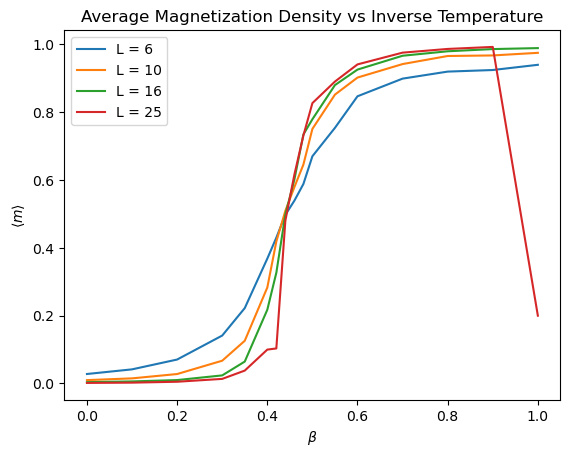

In [537]:
plot_avg_magnetization(grid_mh_mag)

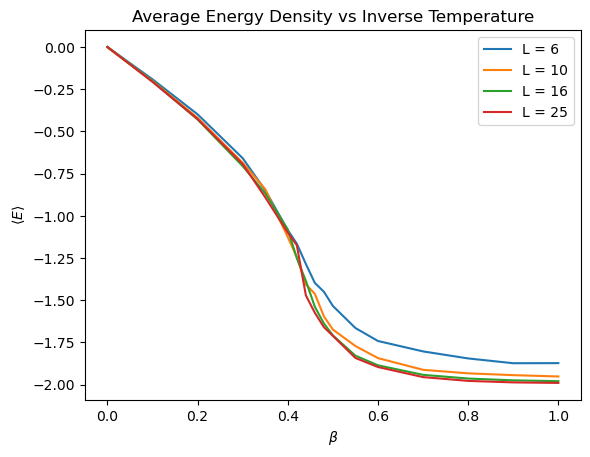

In [305]:
plot_avg_energy(grid_gibbs_energy)

In [108]:
@jit(nopython=True)
def correlation(converged_samples, i, j):
    # Assuming samples is a numpy array and already in memory, adjust slicing accordingly
    sigma_is = converged_samples[:, i[0], i[1]]
    sigma_js = converged_samples[:, j[0], j[1]]

    mean_sigma_is = np.mean(sigma_is)
    mean_sigma_js = np.mean(sigma_js)

    correlation_value = np.mean((sigma_is - mean_sigma_is) * (sigma_js - mean_sigma_js))
    return correlation_value

In [196]:
ten_gibbs_fixed_time_res , ten_gibbs_updated_res = sampler('gibbs', generate_lattice(16, 0.5), 0.42, 4_000_000)

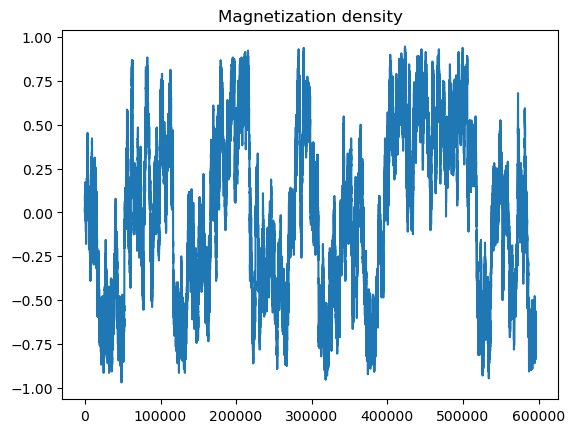

In [172]:
plot_magnetization(ten_gibbs_updated_res)

In [93]:
correlation(np.array(ten_gibbs_updated_res), (1,1), (2,3))

0.1053080164994169

In [94]:
@jit(nopython=True)
def periodic_distance(i, j, size):
    # Initialize the sum to zero
    dist_squared = 0
    # Calculate distance considering periodic boundary conditions
    for x, y in zip(i, j):
        delta = abs(x - y)
        min_delta = min(delta, size - delta)
        dist_squared += min_delta ** 2
    return np.sqrt(dist_squared)

In [95]:
periodic_distance((4,5), (9,4), 10)

5.0990195135927845

In [96]:
def correlation_distance(samples):
    n = samples[0].shape[0]  # Assuming a square lattice
    correlations = {}
    converged_samples = get_converged_samples(samples)

    # Calculate all correlations and organize by rounded distance
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    d = periodic_distance((i, j), (k, l), n)
                    d_rounded = round(d, 1)  # Round to handle floating-point precision issues
                    if d_rounded not in correlations:
                        correlations[d_rounded] = []
                    correlations[d_rounded].append(correlation(converged_samples, (i, j), (k, l)))

    # Calculate average correlation for each distance
    correlation_by_distance = {d: np.mean(correlations[d]) for d in correlations}

    return correlation_by_distance

In [97]:
correlation_distance(ten_gibbs_updated_res)

{0.0: 0.998703763200426,
 1.0: 0.3402375068096024,
 2.0: 0.1333147061057247,
 3.0: 0.05665959501896289,
 4.0: 0.02756103927354647,
 5.0: 0.011194078185753749,
 1.4: 0.19556068045349867,
 2.2: 0.09617913822193323,
 3.2: 0.044740153451791824,
 4.1: 0.02324248781182872,
 5.1: 0.016182628578488095,
 2.8: 0.05686807984338262,
 3.6: 0.03000578001059087,
 4.5: 0.01630764649416959,
 5.4: 0.013461664650954195,
 4.2: 0.017323459655457892,
 5.8: 0.009256391460817496,
 5.7: 0.0039021002971766448,
 6.4: 0.00426014250637837,
 7.1: 0.002894341929343777}

In [98]:
def plot_correlation(corr_dict: dict):
    sorted_dict_items = sorted(corr_dict.items())
    d, corr = zip(*sorted_dict_items)
    plt.plot(d, corr)
    plt.title("Correlation Length")

In [233]:
betas_sixteen = [0.3, 0.4, 0.44, 0.5, 0.6]

In [296]:
sixteen_gibbs_updated_res_lst = []
for beta in betas_sixteen:
    sixteen_gibbs_fixed_time_res, sixteen_gibbs_updated_res = sampler('gibbs', generate_lattice(16, 0.5), beta, 2_000_000)
    sixteen_gibbs_updated_res_lst.append(sixteen_gibbs_updated_res)

In [ ]:
def plot_correlation_distance(samples):
    for sample, beta in zip(samples, betas_sixteen):
        converged_sample = get_converged_samples(sample)
        corr_dict = correlation_distance(converged_sample)
        sorted_dict_items = sorted(corr_dict.items())
        d, corr = zip(*sorted_dict_items)
        plt.plot(d, corr, label = rf"$\beta$ = {beta}")
    plt.xlabel("d")
    plt.ylabel("C(d)")
    plt.legend()    
    plt.title("Correlation Length")
    plt.savefig('corr_len.png', transparent=True)

In [325]:
def plot_log_log_correlation_distance(samples):
    for sample, beta in zip(samples, betas_sixteen):
        converged_sample = get_converged_samples(sample)
        corr_dict = correlation_distance(converged_sample)
        sorted_dict_items = sorted(corr_dict.items())
        d, corr = zip(*sorted_dict_items)
        d, corr = np.array(d), np.array(corr)
        if beta <= 0.3 or beta >= 0.5:
            corr += 10e-4
        plt.plot(np.log(d), np.log(corr * 10e2), label = rf"$\beta$ = {beta}")
    plt.xlabel("log d")
    plt.ylabel("log 100C(d)")
    plt.legend()    
    plt.title("Log-log Correlation Length")
    plt.savefig('log_log_corr_len.png', transparent=True)

/var/folders/q4/tnc3p4jx2zd5h9brq9tycc_40000gn/T/ipykernel_7368/1593052160.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(d), np.log(corr * 10e2), label = rf"$\beta$ = {beta}")
/var/folders/q4/tnc3p4jx2zd5h9brq9tycc_40000gn/T/ipykernel_7368/1593052160.py:10: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(d), np.log(corr * 10e2), label = rf"$\beta$ = {beta}")


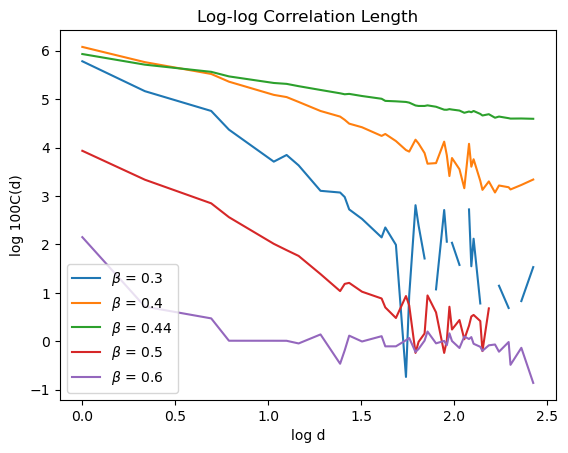

In [326]:
plot_log_log_correlation_distance(sixteen_gibbs_updated_res_lst)

In [118]:
def size_of_clusters(lattice: np.ndarray) -> list:
    lattice_copy = lattice.copy()
    L = lattice.shape[0]
    def dfs(grid, x, y, spin):
        if grid[x][y] == 0 or grid[x][y] != spin:
            return 0

        grid[x][y] = 0

        size = 1
        
        size += dfs(grid, (x+1)%L, y, spin)
        size += dfs(grid, (x-1)%L, y, spin)
        size += dfs(grid, x, (y+1)%L, spin)
        size += dfs(grid, x, (y-1)%L, spin)

        return size
    
    cluster_sizes = []
    for i in range(L):
        for j in range(L):
            if lattice_copy[i][j] != 0:
                size = dfs(lattice_copy, i ,j, lattice_copy[i][j])
                if size > 0:
                    cluster_sizes.append(size)

    return cluster_sizes

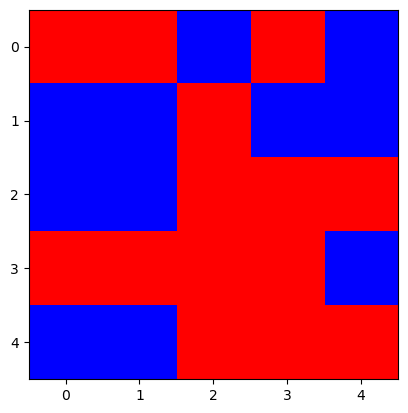

In [120]:
cluster_sz_test_case = generate_lattice(5, 0.5)
plot_lattice(cluster_sz_test_case)

In [121]:
print(size_of_clusters(cluster_sz_test_case))

[2, 1, 12, 7, 1, 2]


In [208]:
def distro_cluster_size(converged_samples: np.ndarray) -> dict:
    freq_map = defaultdict(int)
    for sample in converged_samples:
        lst_of_cluster_sizes = size_of_clusters(sample)
        for cluster_sz in lst_of_cluster_sizes:
            freq_map[cluster_sz] += 1
    

    return freq_map

In [209]:
cluster_data = distro_cluster_size(get_converged_samples(ten_gibbs_updated_res))

In [210]:
cluster_data

defaultdict(int,
            {207: 2759,
             1: 889818,
             23: 3697,
             5: 49582,
             2: 262897,
             8: 21776,
             208: 2798,
             24: 3286,
             209: 2849,
             6: 36698,
             210: 2778,
             211: 2812,
             212: 2846,
             4: 72363,
             22: 3867,
             213: 2786,
             21: 4249,
             7: 28150,
             206: 2714,
             9: 18480,
             205: 2588,
             3: 118843,
             204: 2559,
             26: 2808,
             203: 2542,
             202: 2516,
             10: 15495,
             25: 3077,
             201: 2487,
             200: 2477,
             11: 13182,
             13: 9743,
             14: 8482,
             214: 2768,
             215: 2761,
             216: 2812,
             217: 2876,
             218: 2935,
             20: 4542,
             19: 4916,
             15: 7295,
             17:

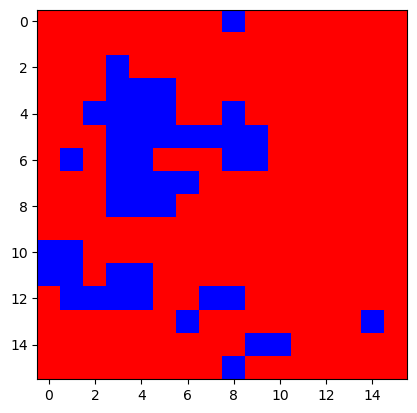

In [198]:
#4 min with list.extend
plot_lattice(ten_gibbs_updated_res[-10_000])

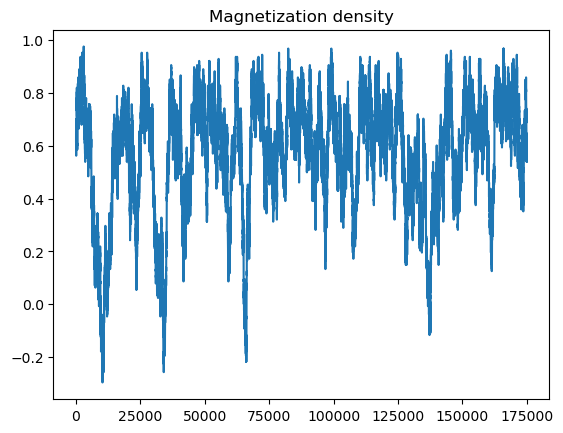

In [199]:
plot_magnetization(get_converged_samples(ten_gibbs_updated_res))

In [298]:
def plot_cluster_log_log_plot(samples):
    for beta, sample in zip(betas_sixteen, samples):
        converged_sample = get_converged_samples(sample)
        cluster_dict = distro_cluster_size(converged_sample)
        freq_map_items = sorted(cluster_dict.items())
        x, y = zip(*freq_map_items)
        log_x, log_y = np.log(np.array(x)), np.log(np.array(y))
        plt.plot(log_x, log_y, label = rf"$\beta$ = {beta}")
    plt.xlabel("log cluster size")
    plt.ylabel("log probability density")
    plt.legend()
    plt.title("Log-Log plot of probability distribution of cluster size")
    plt.savefig('cluster_size.png', transparent=True)

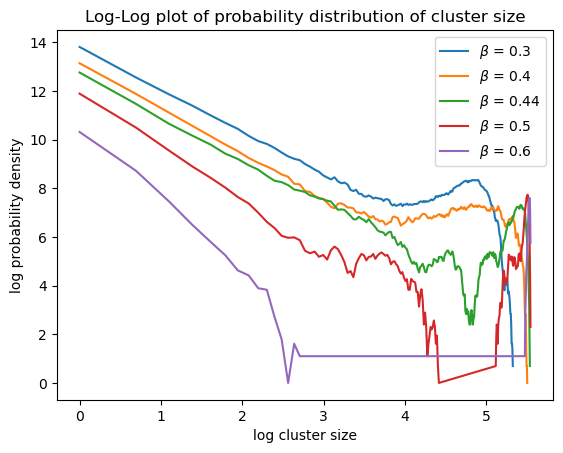

In [299]:
plot_cluster_log_log_plot(sixteen_gibbs_updated_res_lst)